# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


In [1]:
# Some of the pre-loaded imports
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
# from nltk.corpus import stopwords ### add in later
from string import punctuation
from wordcloud import WordCloud 

In [2]:
# Additional import statements made here
np.int = np.int_
np.float = np.float_
# pip uninstall nltk
# pip install -U nltk
# restart notebook
import nltk
import zipfile
import shutil
import html
import matplotlib
import matplotlib.pyplot as plt

#first, download the stopwords.zip file from https://www.nltk.org/nltk_data/ and then extract it
source_dir = '/Users/calebmccurdy/downloads/stopwords'
dest_dir = '/Users/calebmccurdy/nltk_data/corpora/stopwords'

if os.path.exists(dest_dir):
    shutil.rmtree(dest_dir)
shutil.move(source_dir, dest_dir)

#first, download the punkt.zip file from https://www.nltk.org/nltk_data/ and then extract it
punkt_source_dir = '/Users/calebmccurdy/downloads/punkt'
punkt_dest_dir = '/Users/calebmccurdy/nltk_data/corpora/punkt'

if os.path.exists(punkt_dest_dir):
    shutil.rmtree(punkt_dest_dir)
shutil.move(punkt_source_dir, punkt_dest_dir)

'/Users/calebmccurdy/nltk_data/corpora/punkt'

In [3]:
# Final remaining pre-loaded imports
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [12]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")
stopwords_set = set()
for word in sw :
    stopwords_set.add(word)

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_most_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = len(set(tokens)) / len(tokens)
    num_characters = sum(len(token) for token in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")

        counter = Counter(tokens)
        most_common_tokens = counter.most_common(num_most_tokens)
        print(f"Five most common tokens: {most_common_tokens}")
    
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)

def remove_stop(text, stop_set=stopwords_set) : 
    return(" ".join([word for word in text.split() if word.lower() not in stop_set]))
    #return(" ".join([word for word in text if word.lower() not in stop_set]))

def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    tokens = re.split(whitespace_pattern, text)
    return(tokens)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


In [153]:
###
### Can use this code chunk to test the definition success
###

#text_example = "forty $f gets the #dgh1 HAppy, pary..! f1n 23ed #4f:"
#text_examples = remove_punctuation(text_example)
#text_examples = remove_stop(text_examples)
#text_examples = tokenize(text_examples)
#print(text_examples)

#text_example2 = "She likes my cats and my cats like my sofa."
#text_examples2 = remove_stop(text_example2)
#text_examples2 = remove_punctuation(text_examples2)
#text_examples2 = tokenize(text_examples2)
#print(text_examples2)

## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [6]:
data_location = "/Users/calebmccurdy/Desktop/USD/ADS 509/Lyrics Assignment/"
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [158]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [14]:
twitter_data.head(5)

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher


In [23]:
# read in the lyrics here

# Define path to the lyrics folder
lyrics_folder_path = os.path.join(data_location, lyrics_folder)

# Dictionary to store lyrics and title data
lyrics_file_data = {}
title_data = {}
lyrics_only_data = {}

# Loop through each artist subfolder in the lyrics folder
for artist_folder in os.listdir(lyrics_folder_path):
    artist_path = os.path.join(lyrics_folder_path, artist_folder)

    # Check if it's a directory
    if os.path.isdir(artist_path):
        artist = artist_folder
        lyrics_file_data.setdefault(artist, {})
        title_data.setdefault(artist, {})
        lyrics_only_data.setdefault(artist, {})
        # Loop through each txt file in the artist subfolder
        for file_name in os.listdir(artist_path):
        
            # Extract song name from the file name
            song = os.path.splitext(file_name)[0]
            file_path = os.path.join(artist_path, file_name)
                
            # Read the entire text data from the file
            # https://www.dataquest.io/blog/read-file-python/ 
            with open(file_path, 'r') as file:
                text_data = file.read()
                lyrics_file_data[artist][song] = text_data

            with open(file_path, 'r') as f:
                text_data_line = f.readline()
                title_data[artist][song] = text_data_line

            with open(file_path, 'r') as f:
                # skip the first line
                skip = f.readline() 
                text_data_only = f.read()
                lyrics_only_data[artist][song] = text_data_only


# Now, we have the whole file data in the 'lyrics_file_data' dictionary with artist and song names as keys.
# We also have the title data in the 'title_data' dictionary with artist and song names as keys.
# We also have the lyrics data without the title in the 'lyrics_only_data' dictionary with artist and song names as keys.

In [156]:
# Flatten the nested dictionary
flat_lyrics_data = [(artist, song, lyrics) for artist, songs in lyrics_only_data.items() for song, lyrics in songs.items()]

# Create a DataFrame
columns = ["Artist", "Song", "lyrics"]
lyrics_data = pd.DataFrame(flat_lyrics_data, columns=columns)

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [31]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, remove_stop, tokenize]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 

In [43]:
twitter_data.head(5)

,screen_name,name,id,location,followers_count,friends_count,description,artist,tokens,num_tokens,has_emoji
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher,[nan],1,False
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher,"[𝙿𝚛𝚘𝚞𝚍, 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛, 𝚘𝚏, 𝚖𝚎𝚜𝚜𝚢, 𝚋𝚞𝚗𝚜, 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜]",6,False
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher,"[163㎝／愛かっぷ💜26歳🍒, 工〇好きな女の子💓, フォローしてくれたらdmします🧡]",3,True
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher,[csu],1,False
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher,"[writer, washinformer, spelmancollege, alumna,...",17,False


In [159]:
###
### This code can be used to test the pipeline
###

#text_example = "forty $f fortyy cover covering gets the #dgh1 HAppy, pary..! f1n 23ed #4f:"
#testing_example = prepare(text_example, pipeline=my_pipeline)
#print(testing_example)

In [35]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [36]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
270114,robyn,🐩,[🐩]
3688039,cher,I'm a leader y'all on sum followin shit ♓️ ✨,"[im, leader, yall, sum, followin, shit, ♓️, ✨]"
3465183,cher,GDL📌,[gdl📌]
37919,robyn,✨find me outside at nite ✨,"[✨find, outside, nite, ✨]"
1054791,cher,24 | Hull 📍 marketing grad. Liverpool FC fan 😚❤️🔴,"[24, hull, 📍, marketing, grad, liverpool, fc, ..."
722250,cher,RUM 🏳️‍🌈 • ig: zory.ocas • Más gay que tu.,"[rum, 🏳️‍🌈, •, ig, zoryocas, •, más, gay, que,..."
17205,robyn,“And if were searching for peace how come we s...,"[“and, searching, peace, come, still, believe,..."
31432,cher,"Proud Wife, Mom and Grandmother. Honored to be...","[proud, wife, mom, grandmother, honored, membe..."
5953,cher,"26 ,, living here and there in CA ᘛ⁐̤ᕐᐷ ˎˊ˗ pp...","[26, living, ca, ᘛ⁐̤ᕐᐷ, ˎˊ˗, ppl, call, rude, ..."
2553225,cher,just a speck of space dust tryna find a purpos...,"[speck, space, dust, tryna, find, purpose, lif..."


In [137]:
# lyrics data
cher_lyrics_data = lyrics_data[lyrics_data["Artist"] == "cher"]
robyn_lyrics_data = lyrics_data[lyrics_data["Artist"] == "robyn"]
cityalight_lyrics_data = lyrics_data[lyrics_data["Artist"] == "CityAlight"]
patbarrett_lyrics_data = lyrics_data[lyrics_data["Artist"] == "PatBarrett"]

cher_lyrics = [token for sublist in cher_lyrics_data["tokens"] for token in sublist if token != "nan"]
robyn_lyrics = [token for sublist in robyn_lyrics_data["tokens"] for token in sublist if token != "nan"]
cityalight_lyrics = [token for sublist in cityalight_lyrics_data["tokens"] for token in sublist if token != "nan"]
patbarrett_lyrics = [token for sublist in patbarrett_lyrics_data["tokens"] for token in sublist if token != "nan"]

# twitter data
cher_twitter_data = twitter_data[twitter_data["artist"] == "cher"]
robyn_twitter_data = twitter_data[twitter_data["artist"] == "robyn"]

cher_twitter = [token for sublist in cher_twitter_data["tokens"] for token in sublist if token != "nan"]
robyn_twitter = [token for sublist in robyn_twitter_data["tokens"] for token in sublist if token != "nan"]

With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One area of improvement could be to use stemming after the tokenization to match lemmas, or synonyms, together rather than leaving them separated. 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [40]:
# Group the DataFrame by "Artist"
grouped_by_artist = lyrics_data.groupby("Artist")

# Iterate over each group (each artist)
for artist, group_df in grouped_by_artist:
    # Combine all tokens for the artist
    all_artist_lyric_tokens = [token for sublist in group_df["tokens"] for token in sublist]
    
    print(f"\nDescriptive Stats for Lyrics - Artist: {artist}")
    descriptive_stats(all_artist_lyric_tokens, verbose=True)


Descriptive Stats for Lyrics - Artist: CityAlight
There are 5181 tokens in the data.
There are 835 unique tokens in the data.
There are 25929 characters in the data.
The lexical diversity is 0.161 in the data.
Five most common tokens: [('jesus', 183), ('god', 144), ('lord', 77), ('love', 73), ('hope', 72)]

Descriptive Stats for Lyrics - Artist: PatBarrett
There are 8186 tokens in the data.
There are 1148 unique tokens in the data.
There are 39325 characters in the data.
The lexical diversity is 0.140 in the data.
Five most common tokens: [('love', 272), ('oh', 197), ('lord', 175), ('praise', 147), ('im', 123)]

Descriptive Stats for Lyrics - Artist: cher
There are 35233 tokens in the data.
There are 3684 unique tokens in the data.
There are 169244 characters in the data.
The lexical diversity is 0.105 in the data.
Five most common tokens: [('love', 966), ('im', 511), ('know', 480), ('dont', 430), ('youre', 332)]

Descriptive Stats for Lyrics - Artist: robyn
There are 15041 tokens in 

In [45]:
# Group the DataFrame by "artist"
grouped_by_artist2 = twitter_data.groupby("artist")

# Iterate over each group (each artist)
for artist, grouped_df in grouped_by_artist2:
    # Combine all tokens for the artist
    all_artist_twitter_tokens = [token for sublist in grouped_df["tokens"] for token in sublist if token != "nan"]
    
    print(f"\nDescriptive Stats for Twitter Descriptions - Artist: {artist}")
    descriptive_stats(all_artist_twitter_tokens, verbose=True)


Descriptive Stats for Twitter Descriptions - Artist: cher
There are 15688354 tokens in the data.
There are 1555372 unique tokens in the data.
There are 93388505 characters in the data.
The lexical diversity is 0.099 in the data.
Five most common tokens: [('love', 213522), ('im', 139051), ('life', 122679), ('music', 86733), ('de', 72970)]

Descriptive Stats for Twitter Descriptions - Artist: robyn
There are 1497029 tokens in the data.
There are 258391 unique tokens in the data.
There are 9158513 characters in the data.
The lexical diversity is 0.173 in the data.
Five most common tokens: [('music', 14858), ('love', 11615), ('im', 9049), ('och', 7922), ('life', 7354)]


Q: what observations do you make about these data? 

A: Leaving stopwords in the data would have likely resulted in them making up most, if not all, of the "top 5 words" list. We can witness this as "im", which comes from "I'm", is not listed as a stopword despite its similar nature. This word is in the "top 5 words" of every call besides for CityAlight's lyrics. Love is a commonly used word among the lyrics as well as Twitter descriptions for these four artists as it appears in the top 5 lists for all. 

I would have expected the lexical diversity of the Twitter descriptions to be higher given that they are taken from a wide range of individuals, however the large amount of total tokens limits the ability for many of them to be a new unique one. Worship songs often have lower lexical diversities as they are repetitive and have many word/message similarities to other songs. The lexical diversities from CityAlight and Pat Burrett appear on the higher side compared to the Cher lyrics due to the lesser amount of songs, and thus total words. 

## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [46]:
def get_word_frac(word, fd_corpus, length) :
    if word in fd_corpus :
        return(fd_corpus[word]/length)
    else :
        return(0)

def get_ratio(word, fd_corpus_1, fd_corpus_2, len_1, len_2) :
    frac_1 = get_word_frac(word, fd_corpus_1, len_1)
    frac_2 = get_word_frac(word, fd_corpus_2, len_2)

    if frac_2 > 0 :
        return(frac_1/frac_2)
    else :
        return(float('NaN'))

In [119]:
def compare_texts(corpus_1, corpus_2, artist_1, artist_2, num_words = 10, ratio_cutoff=5) :
    
    results = dict()

    results["one"] = descriptive_stats(corpus_1, num_words)
    results["two"] = descriptive_stats(corpus_2, num_words)

    fd_1 = FreqDist(corpus_1)
    fd_2 = FreqDist(corpus_2)

    fd_1_words = set(fd_1.keys())
    fd_2_words = set(fd_2.keys())

    holder1 = dict()
    holder2 = dict()

    results[artist_1 + "_vs_" + artist_2] = dict()
    results[artist_2 + "_vs_" + artist_1] = dict()

    for word, count in fd_1.items() :
        if count > ratio_cutoff and word in fd_2_words and fd_2[word] > ratio_cutoff :
            holder1[word] = get_ratio(word, fd_1, fd_2, results["one"][0], results["two"][0])

    num_added1 = 0

    for word, frac in sorted(holder1.items(), key=lambda item: -1*item[1]) :
        results[artist_1 + "_vs_" + artist_2][word] = frac
        num_added1 += 1
        if num_added1 == num_words :
            break

    for word, count in fd_2.items() :
        if count > ratio_cutoff and word in fd_1_words and fd_1[word] > ratio_cutoff :
            holder2[word] = get_ratio(word, fd_2, fd_1, results["two"][0], results["one"][0])

    num_added2 = 0

    for word, frac in sorted(holder2.items(), key=lambda item: -1*item[1]) :
        results[artist_2 + "_vs_" + artist_1][word] = frac
        num_added2 += 1
        if num_added2 == num_words :
            break
    
    return results

In [133]:
print("Comparing Lyrics: Cher Lyrics vs Robyn Lyrics \n\n")
compare_texts(cher_lyrics, robyn_lyrics, "CherLyrics", "RobynLyrics", num_words=10, ratio_cutoff=3)

Comparing Lyrics: Cher Lyrics vs Robyn Lyrics 


There are 35233 tokens in the data.
There are 3684 unique tokens in the data.
There are 169244 characters in the data.
The lexical diversity is 0.105 in the data.
Five most common tokens: [('love', 966), ('im', 511), ('know', 480), ('dont', 430), ('youre', 332), ('baby', 315), ('time', 313), ('see', 308), ('oh', 306), ('one', 275)]
There are 15041 tokens in the data.
There are 2139 unique tokens in the data.
There are 72804 characters in the data.
The lexical diversity is 0.142 in the data.
Five most common tokens: [('know', 305), ('im', 299), ('dont', 297), ('love', 269), ('got', 249), ('like', 230), ('baby', 220), ('youre', 169), ('never', 155), ('dance', 148)]


{'one': [35233, 3684, 0.10456106491073709, 169244],
 'two': [15041, 2139, 0.1422112891430091, 72804],
 'CherLyrics_vs_RobynLyrics': {'walk': 9.73334090199529,
  'find': 9.605270626969036,
  'enough': 7.562244811074034,
  'without': 7.171935401470213,
  'man': 7.150590355632504,
  'strong': 6.488893934663526,
  'rain': 5.869887605369966,
  'live': 5.805852467856839,
  'believe': 5.394475220802811,
  'young': 5.336261459427242},
 'RobynLyrics_vs_CherLyrics': {'beat': 19.842047423317442,
  'drinking': 18.739711455355362,
  'dance': 13.867386476962968,
  'work': 11.712319659597101,
  'hang': 10.248279702147464,
  'shake': 7.027391795758261,
  'alright': 7.02739179575826,
  'forgive': 7.02739179575826,
  'party': 6.148967821288478,
  '88': 6.0904062229904925}}

In [134]:
print("Comparing Twitter Descriptions: Cher Twitter vs Robyn Twitter \n\n")
compare_texts(cher_twitter, robyn_twitter, "CherTwitter", "RobynTwitter", num_words=10)

Comparing Twitter Descriptions: Cher Twitter vs Robyn Twitter 


There are 15688354 tokens in the data.
There are 1555372 unique tokens in the data.
There are 93388505 characters in the data.
The lexical diversity is 0.099 in the data.
Five most common tokens: [('love', 213522), ('im', 139051), ('life', 122679), ('music', 86733), ('de', 72970), ('follow', 62166), ('lover', 60191), ('like', 58566), ('mom', 53465), ('sheher', 47181)]
There are 1497029 tokens in the data.
There are 258391 unique tokens in the data.
There are 9158513 characters in the data.
The lexical diversity is 0.173 in the data.
Five most common tokens: [('music', 14858), ('love', 11615), ('im', 9049), ('och', 7922), ('life', 7354), ('de', 6382), ('follow', 5570), ('like', 4944), ('en', 4833), ('•', 4829)]


{'one': [15688354, 1555372, 0.09914182201650983, 93388505],
 'two': [1497029, 258391, 0.17260253475383577, 9158513],
 'CherTwitter_vs_RobynTwitter': {'grandmother': 35.81876161132009,
  '#fbr': 24.897437716113068,
  'resister': 24.76907113027008,
  'nana': 23.97501587802009,
  'rbsoul': 20.856730230772275,
  'grandma': 20.162515656400167,
  '#theresistance': 19.150193030925998,
  'hiphoprap': 18.196422307420377,
  'gop': 17.557822573356006,
  'grandchildren': 16.926563066119964},
 'RobynTwitter_vs_CherTwitter': {'sveriges': 205.4013238220502,
  'träning': 200.86013809129062,
  'brinner': 196.11933980093715,
  'följ': 193.0003935572836,
  'gärna': 192.44465404477802,
  'arbetar': 184.82308358755913,
  'varje': 181.64742923038455,
  'familj': 178.15420943749254,
  'projektledare': 172.16583264967767,
  'detta': 163.18326746795535}}

In [135]:
print("Comparing Lyrics to Twitter Descriptions: Cher Lyrics vs Cher Twitter \n\n")
compare_texts(cher_lyrics, cher_twitter, "CherLyrics", "CherTwitter", num_words=10, ratio_cutoff=3)

Comparing Lyrics to Twitter Descriptions: Cher Lyrics vs Cher Twitter 


There are 35233 tokens in the data.
There are 3684 unique tokens in the data.
There are 169244 characters in the data.
The lexical diversity is 0.105 in the data.
Five most common tokens: [('love', 966), ('im', 511), ('know', 480), ('dont', 430), ('youre', 332), ('baby', 315), ('time', 313), ('see', 308), ('oh', 306), ('one', 275)]
There are 15688354 tokens in the data.
There are 1555372 unique tokens in the data.
There are 93388505 characters in the data.
The lexical diversity is 0.099 in the data.
Five most common tokens: [('love', 213522), ('im', 139051), ('life', 122679), ('music', 86733), ('de', 72970), ('follow', 62166), ('lover', 60191), ('like', 58566), ('mom', 53465), ('sheher', 47181)]


{'one': [35233, 3684, 0.10456106491073709, 169244],
 'two': [15688354, 1555372, 0.09914182201650983, 93388505],
 'CherLyrics_vs_CherTwitter': {'ooga': 1497.7412652910623,
  'doodoo': 1133.4258223824256,
  'holdin': 1133.4258223824256,
  'gunman': 801.4939743990009,
  'startin': 763.3275946657152,
  'shoppin': 742.1240503694453,
  'cryin': 627.4321516759857,
  'whatll': 508.88506311047684,
  'plaything': 445.27443022166716,
  'splinters': 400.74698719950044},
 'CherTwitter_vs_CherLyrics': {'wife': 20.873082686048516,
  'lover': 15.019701188679337,
  'en': 14.580895643991713,
  'la': 9.186694142674241,
  'proud': 7.728068080168115,
  'que': 7.0857987475932775,
  'mi': 6.411776213106869,
  'year': 6.399424279946768,
  'music': 6.087046697585355,
  'follow': 6.070120765461077}}

In [136]:
print("Comparing Lyrics to Twitter Descriptions: Robyn Lyrics vs Robyn Twitter \n\n")
compare_texts(robyn_lyrics, robyn_twitter, "RobynLyrics", "RobynTwitter", num_words=10, ratio_cutoff=3)

Comparing Lyrics to Twitter Descriptions: Robyn Lyrics vs Robyn Twitter 


There are 15041 tokens in the data.
There are 2139 unique tokens in the data.
There are 72804 characters in the data.
The lexical diversity is 0.142 in the data.
Five most common tokens: [('know', 305), ('im', 299), ('dont', 297), ('love', 269), ('got', 249), ('like', 230), ('baby', 220), ('youre', 169), ('never', 155), ('dance', 148)]
There are 1497029 tokens in the data.
There are 258391 unique tokens in the data.
There are 9158513 characters in the data.
The lexical diversity is 0.173 in the data.
Five most common tokens: [('music', 14858), ('love', 11615), ('im', 9049), ('och', 7922), ('life', 7354), ('de', 6382), ('follow', 5570), ('like', 4944), ('en', 4833), ('•', 4829)]


{'one': [15041, 2139, 0.1422112891430091, 72804],
 'two': [1497029, 258391, 0.17260253475383577, 9158513],
 'RobynLyrics_vs_RobynTwitter': {'chorus': 945.533907319992,
  'cus': 557.36735589389,
  'digi': 530.8260532322762,
  'intent': 398.1195399242072,
  'indestructible': 398.1195399242072,
  'killing': 356.2122199321854,
  'blissfully': 273.70718369789245,
  'alert': 265.4130266161381,
  'reboot': 199.0597699621036,
  'dropped': 199.0597699621036},
 'RobynTwitter_vs_RobynLyrics': {'och': 19.898546053550067,
  'som': 8.293991298765755,
  'la': 8.080487585744832,
  'live': 6.474437302149791,
  'living': 6.086111725290559,
  'music': 5.147648142904472,
  'jag': 5.081890731575674,
  'food': 3.825986537334948,
  'best': 3.112967862791346,
  'old': 3.0526844614677917}}

In [131]:
print("Comparing Lyrics to Twitter Descriptions: Cher Lyrics vs Robyn Twitter \n\n")
compare_texts(cher_lyrics, robyn_twitter, "CherLyrics", "RobynTwitter", num_words=10, ratio_cutoff=3)

Comparing Lyrics to Twitter Descriptions: Cher Lyrics vs Robyn Twitter 


There are 35233 tokens in the data.
There are 3684 unique tokens in the data.
There are 169244 characters in the data.
The lexical diversity is 0.105 in the data.
Five most common tokens: [('love', 966), ('im', 511), ('know', 480), ('dont', 430), ('youre', 332), ('baby', 315), ('time', 313), ('see', 308), ('oh', 306), ('one', 275)]
There are 1497029 tokens in the data.
There are 258391 unique tokens in the data.
There are 9158513 characters in the data.
The lexical diversity is 0.173 in the data.
Five most common tokens: [('music', 14858), ('love', 11615), ('im', 9049), ('och', 7922), ('life', 7354), ('de', 6382), ('follow', 5570), ('like', 4944), ('en', 4833), ('•', 4829)]


{'one': [35233, 3684, 0.10456106491073709, 169244],
 'two': [1497029, 258391, 0.17260253475383577, 9158513],
 'CherLyrics_vs_RobynTwitter': {'chorus': 424.8939914284903,
  'runnin': 276.18109442851875,
  'cryin': 263.43427468566404,
  'ooh': 212.44699571424516,
  'fernando': 155.7944635237798,
  'womans': 144.46395708568673,
  'waterloo': 141.63133047616344,
  'carousel': 138.09054721425937,
  'takin': 135.96607725711692,
  'bells': 135.96607725711692},
 'RobynTwitter_vs_CherLyrics': {'en': 28.43650473704918,
  'lover': 12.447549260717208,
  'music': 10.927725723750173,
  'la': 7.57130028877196,
  'que': 6.551634186779281,
  'follow': 5.699631388744553,
  'dad': 5.3307414218428635,
  'wife': 4.718824084236177,
  'year': 4.642334417035341,
  'games': 4.418749235986744}}

In [132]:
print("Comparing Lyrics to Twitter Descriptions: Robyn Lyrics vs Cher Twitter \n\n")
compare_texts(robyn_lyrics, cher_twitter, "RobynLyrics", "CherTwitter", num_words=10, ratio_cutoff=3)

Comparing Lyrics to Twitter Descriptions: Robyn Lyrics vs Cher Twitter 


There are 15041 tokens in the data.
There are 2139 unique tokens in the data.
There are 72804 characters in the data.
The lexical diversity is 0.142 in the data.
Five most common tokens: [('know', 305), ('im', 299), ('dont', 297), ('love', 269), ('got', 249), ('like', 230), ('baby', 220), ('youre', 169), ('never', 155), ('dance', 148)]
There are 15688354 tokens in the data.
There are 1555372 unique tokens in the data.
There are 93388505 characters in the data.
The lexical diversity is 0.099 in the data.
Five most common tokens: [('love', 213522), ('im', 139051), ('life', 122679), ('music', 86733), ('de', 72970), ('follow', 62166), ('lover', 60191), ('like', 58566), ('mom', 53465), ('sheher', 47181)]


{'one': [15041, 2139, 0.1422112891430091, 72804],
 'two': [15688354, 1555372, 0.09914182201650983, 93388505],
 'RobynLyrics_vs_CherTwitter': {'deng': 6675.451472641446,
  'digi': 1335.0902945282894,
  'conceal': 1327.5045542184696,
  'switches': 1192.0449058288298,
  'authorities': 1043.039292600226,
  'trigga': 782.2794694501695,
  'konichiwa': 730.1275048201582,
  'ignition': 695.3595284001507,
  'indestructible': 695.3595284001507,
  'indecent': 608.4395873501319},
 'CherTwitter_vs_RobynLyrics': {'la': 9.804520378619708,
  'live': 8.900719336139407,
  'family': 8.292832361508417,
  'living': 7.962787268823741,
  '2': 6.3868638959829696,
  'old': 4.66153739476642,
  'proud': 4.2417248762089015,
  'best': 4.240172635914089,
  'god': 3.697208111613664,
  'name': 3.296903601231844}}

In [138]:
print("Comparing Lyrics: CityAlight Lyrics vs Pat Barrett Lyrics \n\n")
compare_texts(cityalight_lyrics, patbarrett_lyrics, "CityAlightLyrics", "PatBarrettLyrics", num_words=10, ratio_cutoff=3)

Comparing Lyrics: CityAlight Lyrics vs Pat Barrett Lyrics 


There are 5181 tokens in the data.
There are 835 unique tokens in the data.
There are 25929 characters in the data.
The lexical diversity is 0.161 in the data.
Five most common tokens: [('jesus', 183), ('god', 144), ('lord', 77), ('love', 73), ('hope', 72), ('day', 71), ('praise', 69), ('king', 66), ('know', 61), ('come', 59)]
There are 8186 tokens in the data.
There are 1148 unique tokens in the data.
There are 39325 characters in the data.
The lexical diversity is 0.140 in the data.
Five most common tokens: [('love', 272), ('oh', 197), ('lord', 175), ('praise', 147), ('im', 123), ('let', 119), ('youre', 113), ('good', 108), ('sing', 93), ('go', 89)]


{'one': [5181, 835, 0.16116579810847326, 25929],
 'two': [8186, 1148, 0.1402394331785976, 39325],
 'CityAlightLyrics_vs_PatBarrettLyrics': {'king': 26.070063694267517,
  'jesus': 22.241592802102357,
  'christ': 18.328044779000194,
  'blood': 12.24502991700444,
  'hallelujah': 11.85002895193978,
  'side': 10.744026249758734,
  'stand': 8.690021231422506,
  'voice': 7.900019301293187,
  'hand': 6.320015441034549,
  'cross': 6.056681464324776},
 'PatBarrettLyrics_vs_CityAlightLyrics': {'youre': 7.946534734098868,
  'well': 7.753145614463719,
  'within': 7.594918152944051,
  'time': 6.96200830686538,
  'go': 6.258775144555746,
  'im': 5.560565076262609,
  'spirit': 4.9050513071097,
  'cause': 4.701615999441556,
  'breath': 4.050623014903493,
  'wherever': 3.7974590764720255}}

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: I set the appearance cutoff value at 3 when lyrics were involved due to the smaller scale of available tokens, but I left the cutoff at 5 when comparing between Twitter descriptions. When comparing the Cher and Robyn lyrics, none of the ratios were very large with all of them being below 20. This is likely caused by the artists having similar styles of music and will thus share common vocabularies. The same does not hold when looking at their twitter description, though, as all 10 of the top ratios in the Robyn vs. Cher direction were above 160. The ratios from lyrics to twitter were all very high which is likely due to the fact that songs often have high concentrations of words, but this is unlikely to be seen in the twitter descriptions of the artists' followers. 

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [140]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

The word clouds are in the following order: 

 Cher Lyrics 		 Robyn Lyrics 
 CityAlight Lyrics 	 Pat Barrett Lyrics 
 Cher Twitter 		 Robyn Twitter


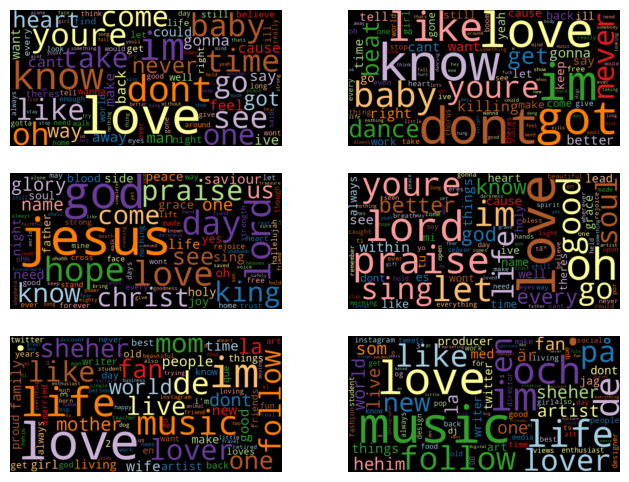

In [152]:
freq_cher_lyrics_df = count_words(cher_lyrics_data)
freq_robyn_lyrics_df = count_words(robyn_lyrics_data)
freq_cityalight_lyrics_df = count_words(cityalight_lyrics_data)
freq_patbarrett_lyrics_df = count_words(patbarrett_lyrics_data)
freq_cher_twitter_df = count_words(cher_twitter_data)
freq_robyn_twitter_df = count_words(robyn_twitter_data)

print("The word clouds are in the following order: \n\n Cher Lyrics \t\t Robyn Lyrics \n CityAlight Lyrics \t Pat Barrett Lyrics \n Cher Twitter \t\t Robyn Twitter")

plt.figure(figsize=(8,6))
plt.subplot(3,2,1)###
wordcloud(freq_cher_lyrics_df['freq'], max_words=100)
plt.subplot(3,2,2)###
wordcloud(freq_robyn_lyrics_df['freq'], max_words=100)
plt.subplot(3,2,3)###
wordcloud(freq_cityalight_lyrics_df['freq'], max_words=100)
plt.subplot(3,2,4)###
wordcloud(freq_patbarrett_lyrics_df['freq'], max_words=100)
plt.subplot(3,2,5)###
wordcloud(freq_cher_twitter_df['freq'], max_words=100, stopwords=freq_cher_twitter_df.head(1).index)
plt.subplot(3,2,6)###
wordcloud(freq_robyn_twitter_df['freq'], max_words=100, stopwords=freq_robyn_twitter_df.head(1).index)
#plt.tight_layout

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: The words in these wordclouds reflect the most common tokens from the six corporas. The interesting words to look at from here are the medium and small sized ones as those have not been seen during our returning of the most common words. Additionally, the size of the words present in the wordclouds allow us to see how much relevance is placed on the most common words as the wordclouds will size them accordingly. For example, the Robyn lyrics have between 5-10 words that appear large or very large whereas "Jesus" and "God" from the CityAlight lyrics appear to dominate the space more.